In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import layers

In [2]:
# read the dataset
(X_train, y_train), (X_test,y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [7]:
y_train.shape

(60000,)

Text(0, 0.5, 'Number of Pixels: Y')

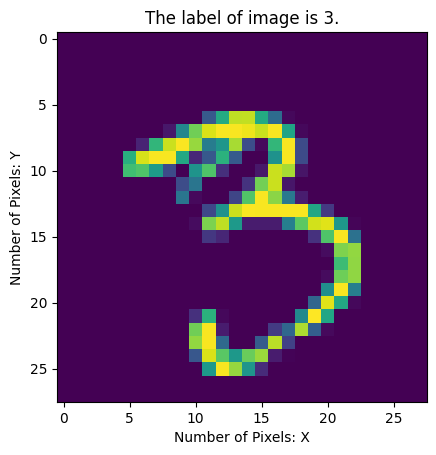

In [29]:
# plot the images from training dataset
i = np.random.randint(0,y_train.shape[0])
image = X_train[i]
plt.imshow(image)
plt.title(f"The label of image is {y_train[i]}.")
plt.xlabel("Number of Pixels: X")
plt.ylabel("Number of Pixels: Y")

In [33]:
def display_image(training_images, training_labels, number_of_images_disply, name_of_dataset):
    
    if not training_images.shape[0] == 0:
        # display images from the dataset
        index= []
        while  len(index) < number_of_images_disply:
            i = np.random.randint(0,training_labels.shape[0])
            index.append(i)

        print(training_images[0])
        
        for ind in range(0,len(index)):

            num_rows = 1  # Number of rows
            num_cols = len(index)  # Number of columns

            # Create a figure with a grid layout
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4))

            # If there is only one image, `axes` is not a list, so we need to convert it to a list
            if num_cols == 1:
                axes = [axes]

            # Iterate through the images and display them
            for i, ax in enumerate(axes):
                ax.imshow(training_images[ind])
                ax.axis('off')
                ax.set_labels(training_labels[ind])

        plt.title(f"Images from datasets {name_of_dataset}")
        plt.show()

    else:
        ValueError("training_x_images doesn't contain images, it is empty")

[14663, 29981, 15981, 56753, 35691]


AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

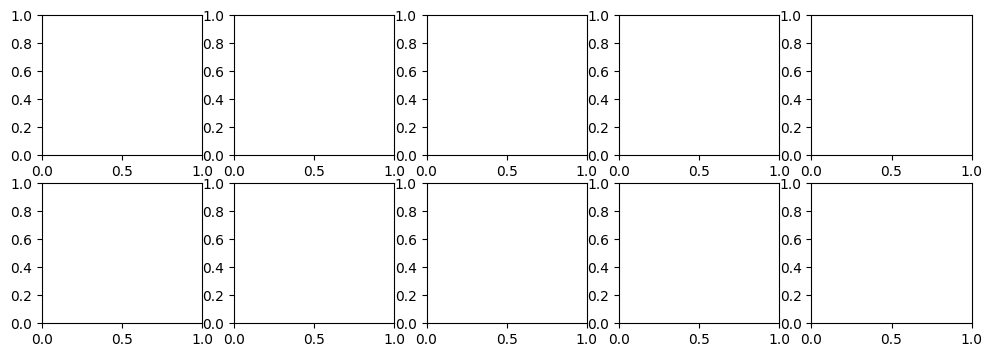

In [34]:
display_image(X_train,y_train,5,"MNIST")